In [7]:
from dotenv import load_dotenv
load_dotenv()

True

In [19]:
ROLES = {
    "1": {
        "name": "一般知識エキスパート",
        "description": "幅広い分野の一般的な質問に答える",
        "details": "幅広い分野の一般的な質問に対して、正確でわかりやすい回答を提供してください。"
    },
    "2": {
        "name": "生成AI製品エキスパート",
        "description": "生成AIや関連製品、技術に関する専門的な質問に答える",
        "details": "生成AIや関連製品、技術に関する専門的な質問に対して、最新の情報と深い洞察を提供してください。"
    },
    "3": {
        "name": "カウンセラー",
        "description": "個人的な悩みや心理的な問題に対してサポートを提供する",
        "details": "個人的な悩みや心理的な問題に対して、共感的で支援的な回答を提供し、可能であれば適切なアドバイスも行ってください。"
    }
}

In [20]:
import operator
from typing import Annotated
from langchain_core.pydantic_v1 import BaseModel, Field

class State(BaseModel):
   query: str = Field(
       ..., description="ユーザーからの質問"
   )
   current_role: str = Field(
       default="", description="選定された回答ロール"
   )
   messages: Annotated[list[str], operator.add] = Field(
       default=[], description="回答履歴"
   )
   current_judge: bool = Field(
       default=False, description="品質チェックの結果"
   )
   judgement_reason: str = Field(
       default="", description="品質チェックの判定理由"
   )

In [8]:
from langchain_openai import ChatOpenAI
from langchain_core.runnables import ConfigurableField
llm = ChatOpenAI(model="gpt-4o", temperature=0.0)
# 後からmax_tokensの値を変更できるように、変更可能なフィールドを宣言
llm = llm.configurable_fields(max_tokens=ConfigurableField(id='max_tokens'))

In [9]:
from typing import Any
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

def selection_node(state: State) -> dict[str, Any]:
   query = state.query
   role_options = "\n".join([f"{k}. {v['name']}: {v['description']}" for k, v in ROLES.items()])

   prompt = ChatPromptTemplate.from_template(
       """質問を分析し、最も適切な回答担当ロールを選択してください。
選択肢:
{role_options}
回答は選択肢の番号（1、2、または3）のみを返してください。
質問: {query}
""".strip()
   )

   # 選択肢の番号のみを返すことを期待したいため、max_tokensの値を1に変更
   chain = prompt | llm.with_config(configurable=dict(max_tokens=1)) | StrOutputParser()
   role_number = chain.invoke({"role_options": role_options, "query": query})
   selected_role = ROLES[role_number.strip()]["name"]

   return {"current_role": selected_role}

In [10]:
def answering_node(state: State) -> dict[str, Any]:
   query = state.query
   role = state.current_role
   role_details = "\n".join([f"- {v['name']}: {v['details']}" for v in ROLES.values()])

   prompt = ChatPromptTemplate.from_template(
       """あなたは{role}として回答してください。以下の質問に対して、あなたの役割に基づいた適切な回答を提供してください。
役割の詳細:
{role_details}
質問: {query}
回答:""".strip()
   )

   chain = prompt | llm | StrOutputParser()
   answer = chain.invoke({"role": role, "role_details": role_details, "query": query})

   return {"messages": [answer]}

In [11]:
class Judgement(BaseModel):
   reason: str = Field(default="", description="判定理由")
   judge: bool = Field(default=False, description="判定結果")

def check_node(state: State) -> dict[str, Any]:
   query = state.query
   answer = state.messages[-1]

   prompt = ChatPromptTemplate.from_template(
       """以下の回答の品質をチェックし、問題がある場合は'False'、問題がない場合は'True'を回答してください。また、その判断理由も説明してください。
ユーザーからの質問: {query}
回答: {answer}
""".strip()
   )

   chain = prompt | llm.with_structured_output(Judgement)
   result: Judgement = chain.invoke({"query": query, "answer": answer})

   return {
       "current_judge": result.judge,
       "judgement_reason": result.reason
   }

In [12]:
from langgraph.graph import StateGraph
workflow = StateGraph(State)

In [13]:
workflow.add_node("selection", selection_node)
workflow.add_node("answering", answering_node)
workflow.add_node("check", check_node)

In [14]:
# selectionノードから処理を開始
workflow.set_entry_point("selection")

In [15]:
# selectionノードからansweringノードへ
workflow.add_edge("selection", "answering")
# answeringノードからcheckノードへ
workflow.add_edge("answering", "check")

In [16]:
from langgraph.graph import END

# checkノードから次のノードへの遷移に条件付きエッジを定義
# state.current_judgeの値がTrueならENDノードへ、Falseならselectionノードへ
workflow.add_conditional_edges(
   "check",
   lambda state: state.current_judge,
   {True: END, False: "selection"}
)

In [17]:
compiled = workflow.compile()

In [ ]:
initial_state = State(query="生成AIについて教えてください")
result = compiled.invoke(initial_state)

In [24]:
print(result["messages"][-1])

生成AI製品エキスパートとしてお答えします。

生成AIとは、人工知能技術の一分野であり、テキスト、画像、音声、動画などのコンテンツを生成する能力を持つモデルを指します。これらのモデルは、大量のデータを学習し、そのパターンを理解することで、新しいコンテンツを生成することができます。

代表的な生成AIの技術には、以下のようなものがあります：

1. **自然言語処理（NLP）モデル**: 例えば、GPT（Generative Pre-trained Transformer）シリーズは、テキストの生成や翻訳、要約などに利用されます。これらのモデルは、人間のように自然な文章を生成することが可能です。

2. **画像生成モデル**: GAN（Generative Adversarial Networks）やVAE（Variational Autoencoders）などの技術を用いて、新しい画像を生成します。これにより、アート作品の創作や、写真の修正、合成が可能になります。

3. **音声合成**: TTS（Text-to-Speech）技術を用いて、テキストから自然な音声を生成します。これにより、音声アシスタントやナレーションの自動生成が可能です。

生成AIは、クリエイティブな分野やビジネスの自動化、教育、医療など、さまざまな分野で活用されています。しかし、倫理的な問題やデータの偏り、プライバシーの保護など、解決すべき課題も存在します。生成AIの進化は急速であり、今後も多くの可能性を秘めています。


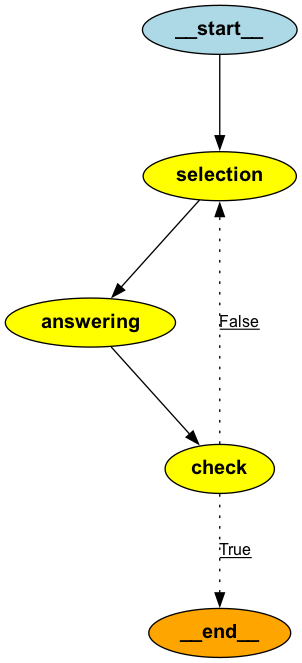

In [25]:
from IPython.display import Image
Image(compiled.get_graph().draw_png())

In [26]:
import operator
from typing import Annotated, Any
from langchain_core.messages import SystemMessage, HumanMessage, BaseMessage
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

# グラフのステートを定義
class State(BaseModel):
   query: str
   messages: Annotated[list[BaseMessage], operator.add] = Field(default=[])

# メッセージを追加するノード関数
def add_message(state: State) -> dict[str, Any]:
   additional_messages = []
   if not state.messages:
       additional_messages.append(
           SystemMessage(content="あなたは最小限の応答をする対話エージェントです。")
       )
   additional_messages.append(HumanMessage(content=state.query))
   return {"messages": additional_messages}

# LLMからの応答を追加するノード関数
def llm_response(state: State) -> dict[str, Any]:
   llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)
   ai_message = llm.invoke(state.messages)
   return {"messages": [ai_message]}

In [27]:
from pprint import pprint
from langchain_core.runnables import RunnableConfig
from langgraph.checkpoint.base import BaseCheckpointSaver

def print_checkpoint_dump(checkpointer: BaseCheckpointSaver, config: RunnableConfig):
   checkpoint_tuple = checkpointer.get_tuple(config)
   print("チェックポイントデータ:")
   pprint(checkpoint_tuple.checkpoint)
   print("\nメタデータ:")
   pprint(checkpoint_tuple.metadata)

In [28]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
# グラフを設定
graph = StateGraph(State)
graph.add_node("add_message", add_message)
graph.add_node("llm_response", llm_response)
graph.set_entry_point("add_message")
graph.add_edge("add_message", "llm_response")
graph.add_edge("llm_response", END)
# チェックポインターを設定
checkpointer = MemorySaver()
# グラフをコンパイル
compiled_graph = graph.compile(checkpointer=checkpointer)

In [29]:
config = {"configurable": {"thread_id": "example-1"}}
user_query = State(query="私の好きなものはずんだ餅です。覚えておいてね。")
first_response = compiled_graph.invoke(user_query, config)
first_response

{'query': '私の好きなものはずんだ餅です。覚えておいてね。',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
  AIMessage(content='了解しました！ずんだ餅ですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 48, 'total_tokens': 59, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BImSTlDj4AcdKHE0HmoMhfOFFk04D', 'finish_reason': 'stop', 'logprobs': None}, id='run-58682591-2866-477c-bb8f-338e4344c5ba-0', usage_metadata={'input_tokens': 48, 'output_tokens': 11, 'total_tokens': 59, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {

In [30]:
for checkpoint in checkpointer.list(config):
    print(checkpoint)

CheckpointTuple(config={'configurable': {'thread_id': 'example-1', 'checkpoint_ns': '', 'checkpoint_id': '1f011bbc-ef44-6c04-8002-89d5d5699703'}}, checkpoint={'v': 3, 'ts': '2025-04-05T01:17:57.715861+00:00', 'id': '1f011bbc-ef44-6c04-8002-89d5d5699703', 'channel_versions': {'__start__': '00000000000000000000000000000002.0.05803536958012234', 'query': '00000000000000000000000000000002.0.06744840091760773', 'messages': '00000000000000000000000000000004.0.12666826683544463', 'branch:to:add_message': '00000000000000000000000000000003.0.9203961101897897', 'branch:to:llm_response': '00000000000000000000000000000004.0.19121666954059957'}, 'versions_seen': {'__input__': {}, '__start__': {'__start__': '00000000000000000000000000000001.0.5384767953337886'}, 'add_message': {'branch:to:add_message': '00000000000000000000000000000002.0.6558269153107993'}, 'llm_response': {'branch:to:llm_response': '00000000000000000000000000000003.0.46297692010916713'}}, 'channel_values': {'query': '私の好きなものはずんだ餅です

In [31]:
print_checkpoint_dump(checkpointer, config)

チェックポイントデータ:
{'channel_values': {'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
                                 HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
                                 AIMessage(content='了解しました！ずんだ餅ですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 48, 'total_tokens': 59, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BImSTlDj4AcdKHE0HmoMhfOFFk04D', 'finish_reason': 'stop', 'logprobs': None}, id='run-58682591-2866-477c-bb8f-338e4344c5ba-0', usage_metadata={'input_tokens': 48, 'output_tokens': 11, 'total_tokens': 59, 'input_token_details':

In [32]:
user_query = State(query="私の好物は何か覚えてる？")
second_response = compiled_graph.invoke(user_query, config)
second_response

{'query': '私の好物は何か覚えてる？',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
  AIMessage(content='了解しました！ずんだ餅ですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 48, 'total_tokens': 59, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BImSTlDj4AcdKHE0HmoMhfOFFk04D', 'finish_reason': 'stop', 'logprobs': None}, id='run-58682591-2866-477c-bb8f-338e4344c5ba-0', usage_metadata={'input_tokens': 48, 'output_tokens': 11, 'total_tokens': 59, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0,

In [33]:
for checkpoint in checkpointer.list(config):
    print(checkpoint)

CheckpointTuple(config={'configurable': {'thread_id': 'example-1', 'checkpoint_ns': '', 'checkpoint_id': '1f011bc3-7089-66ba-8006-a831454ba821'}}, checkpoint={'v': 3, 'ts': '2025-04-05T01:20:52.331893+00:00', 'id': '1f011bc3-7089-66ba-8006-a831454ba821', 'channel_versions': {'__start__': '00000000000000000000000000000006.0.5405201019125592', 'query': '00000000000000000000000000000006.0.13304030652047671', 'messages': '00000000000000000000000000000008.0.7108345238079449', 'branch:to:add_message': '00000000000000000000000000000007.0.29702691141183224', 'branch:to:llm_response': '00000000000000000000000000000008.0.8763074345496498'}, 'versions_seen': {'__input__': {}, '__start__': {'__start__': '00000000000000000000000000000005.0.019754355684266867'}, 'add_message': {'branch:to:add_message': '00000000000000000000000000000006.0.5777555987333399'}, 'llm_response': {'branch:to:llm_response': '00000000000000000000000000000007.0.11111927882377459'}}, 'channel_values': {'query': '私の好物は何か覚えてる？',